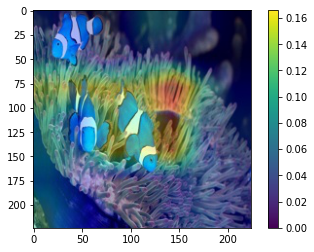

In [3]:
# -*- coding: UTF-8 -*-
import torch
from torchvision import models
import torch.nn as nn
import torchvision.transforms as tfs
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
 
# https://blog.csdn.net/qlq1234/article/details/118020311
class cal_cam(nn.Module):
    def __init__(self, feature_layer="layer4"):
        super(cal_cam, self).__init__()
        self.model = models.resnet50(pretrained=True)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
 
        # 要求梯度的层
        self.feature_layer = feature_layer
        # 记录梯度
        self.gradient = []
        # 记录输出的特征图
        self.output = []
        self.means = [0.485, 0.456, 0.406]
        self.stds = [0.229, 0.224, 0.225]
 
        self.trainsform = tfs.Compose([
            tfs.ToTensor(),
            tfs.Normalize(self.means, self.stds)
        ])
 
    def save_grad(self, grad):
        self.gradient.append(grad)
 
    def get_grad(self):
        return self.gradient[-1].cpu().data
 
    def get_feature(self):
        return self.output[-1][0]
 
    def process_img(self, input):
        input = self.trainsform(input)
        input = input.unsqueeze(0)
        return input
 
    # 计算最后一个卷积层的梯度，输出梯度和最后一个卷积层的特征图
    def getGrad(self, input_):
        input_ = input_.to(self.device).requires_grad_(True)
        num = 1
        for name, module in self.model._modules.items():
            if (num == 1):
                input = module(input_)
                num = num + 1
                continue
            # 是待提取特征图的层
            if (name == self.feature_layer):
                input = module(input)
                input.register_hook(self.save_grad)
                self.output.append([input])
            # 马上要到全连接层了
            elif (name == "avgpool"):
                input = module(input)
                input = input.reshape(input.shape[0], -1)
            # 普通的层
            else:
                input = module(input)
 
        # 到这里input就是最后全连接层的输出了
        index = torch.max(input, dim=-1)[1]
        one_hot = torch.zeros((1, input.shape[-1]), dtype=torch.float32)
        one_hot[0][index] = 1
        confidenct = one_hot * input.cpu()
        confidenct = torch.sum(confidenct, dim=-1).requires_grad_(True)
        # print(confidenct)
        self.model.zero_grad()
        # 反向传播获取梯度
        confidenct.backward(retain_graph=True)
        # 获取特征图的梯度
        grad_val = self.get_grad()
        feature = self.get_feature()
        return grad_val, feature, input_.grad
 
    # 计算CAM
    def getCam(self, grad_val, feature):
        # 对特征图的每个通道进行全局池化
        alpha = torch.mean(grad_val, dim=(2, 3)).cpu()
        feature = feature.cpu()
        # 将池化后的结果和相应通道特征图相乘
        cam = torch.zeros((feature.shape[2], feature.shape[3]), dtype=torch.float32)
        for idx in range(alpha.shape[1]):
            cam = cam + alpha[0][idx] * feature[0][idx]
        # 进行ReLU操作
        cam = np.maximum(cam.detach().numpy(), 0)
 
        plt.imshow(cam)
        plt.colorbar()
        plt.savefig("./cam_output/cam.jpg")
        # 将cam区域放大到输入图片大小
        cam_ = cv2.resize(cam, (224, 224))
        cam_ = cam_ - np.min(cam_)
        cam_ = cam_ / np.max(cam_)
        
        plt.imshow(cam_)
        plt.savefig("./cam_output/cam_.jpg")
        cam = torch.from_numpy(cam)
 
        return cam, cam_
 
    def show_img(self, cam_, img):
        heatmap = cv2.applyColorMap(np.uint8(255 * cam_), cv2.COLORMAP_JET)
        cam_img = 0.3 * heatmap + 0.7 * np.float32(img)
        cv2.imwrite("./cam_output/img.jpg", cam_img)
 
    def __call__(self, img_root):
        img = Image.open(img_root)
        img = img.resize((224, 224))
        plt.imshow(img)
        plt.savefig("./cam_output/cacheimage.jpg")
        input = self.process_img(img)
        grad_val, feature, input_grad = self.getGrad(input)
        cam, cam_ = self.getCam(grad_val, feature)
        self.show_img(cam_, img)
        return cam
 
 
if __name__ == "__main__":
    cam = cal_cam()
    ###########input#######################
    img_root = "fish.jpg"
    ####################################
    cam(img_root)
    plt.imshow(np.array(Image.open('./cam_output/img.jpg')))
    plt.show()
    